# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](ImageNet.png)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [2]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")

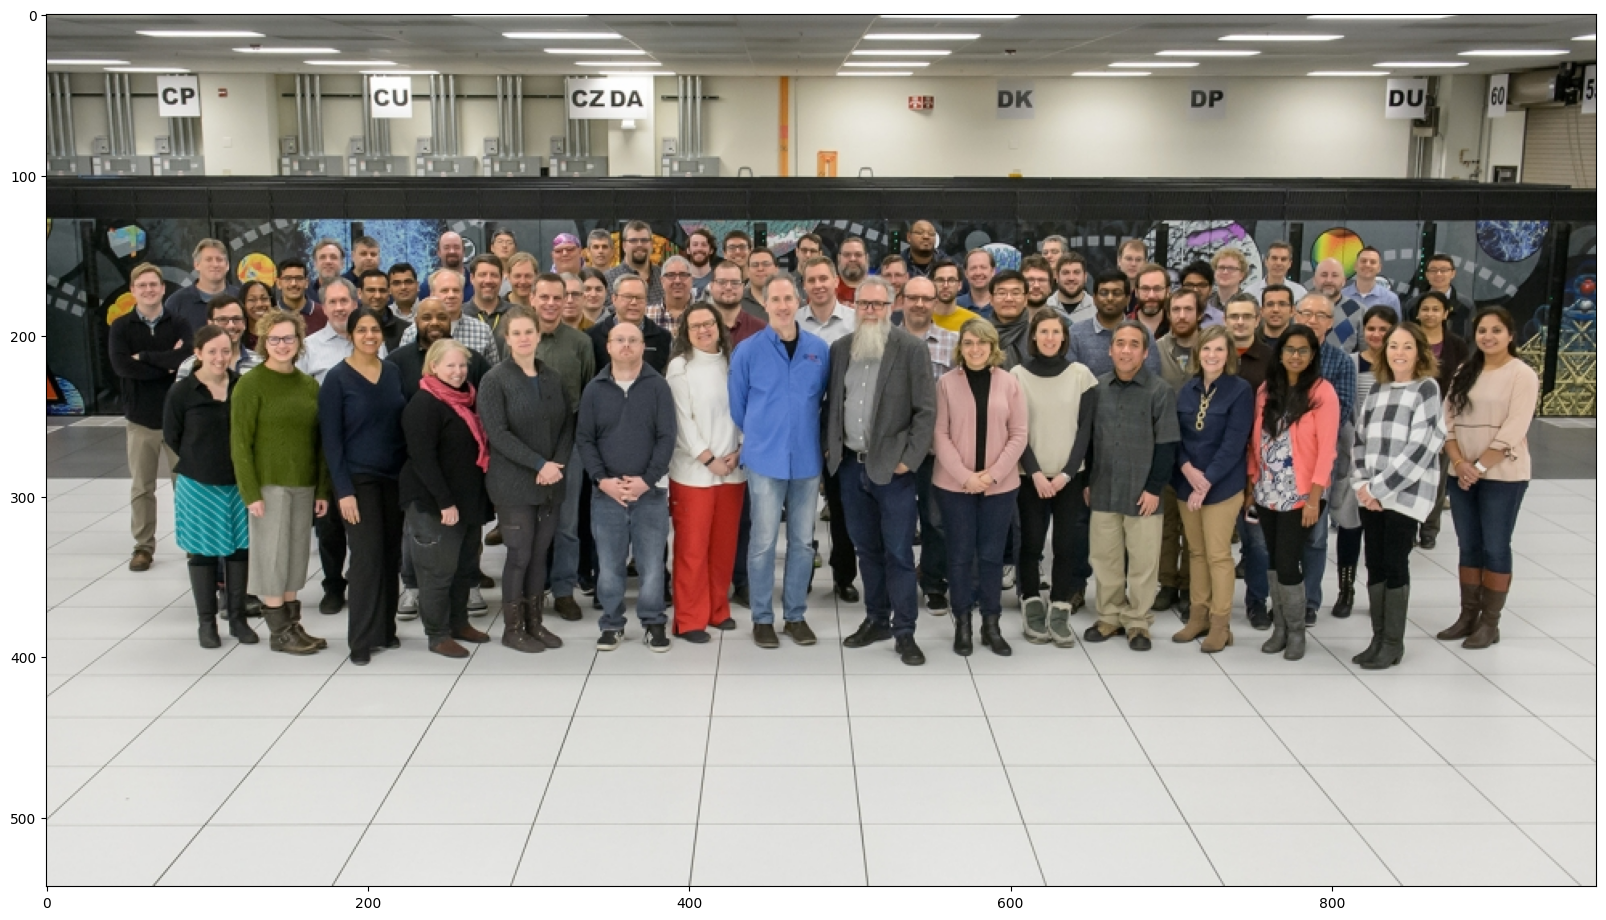

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

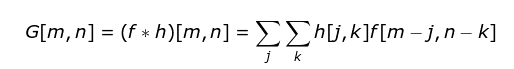

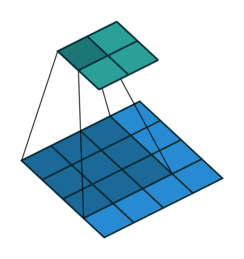


torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


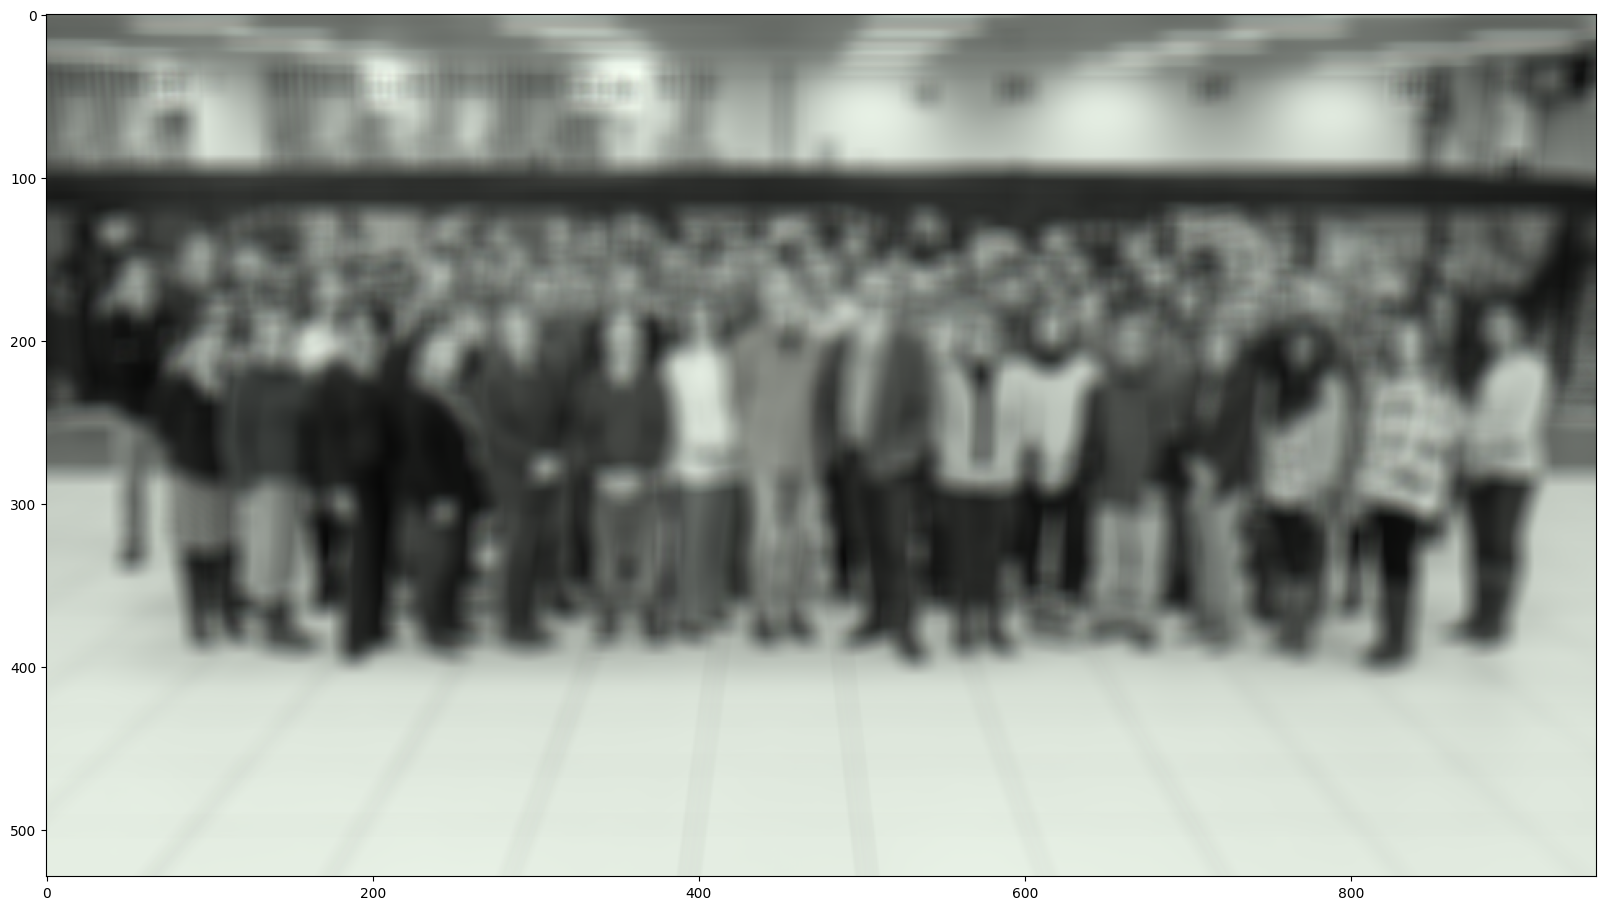

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](batch_norm.png)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](batch_norm_effect.png)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


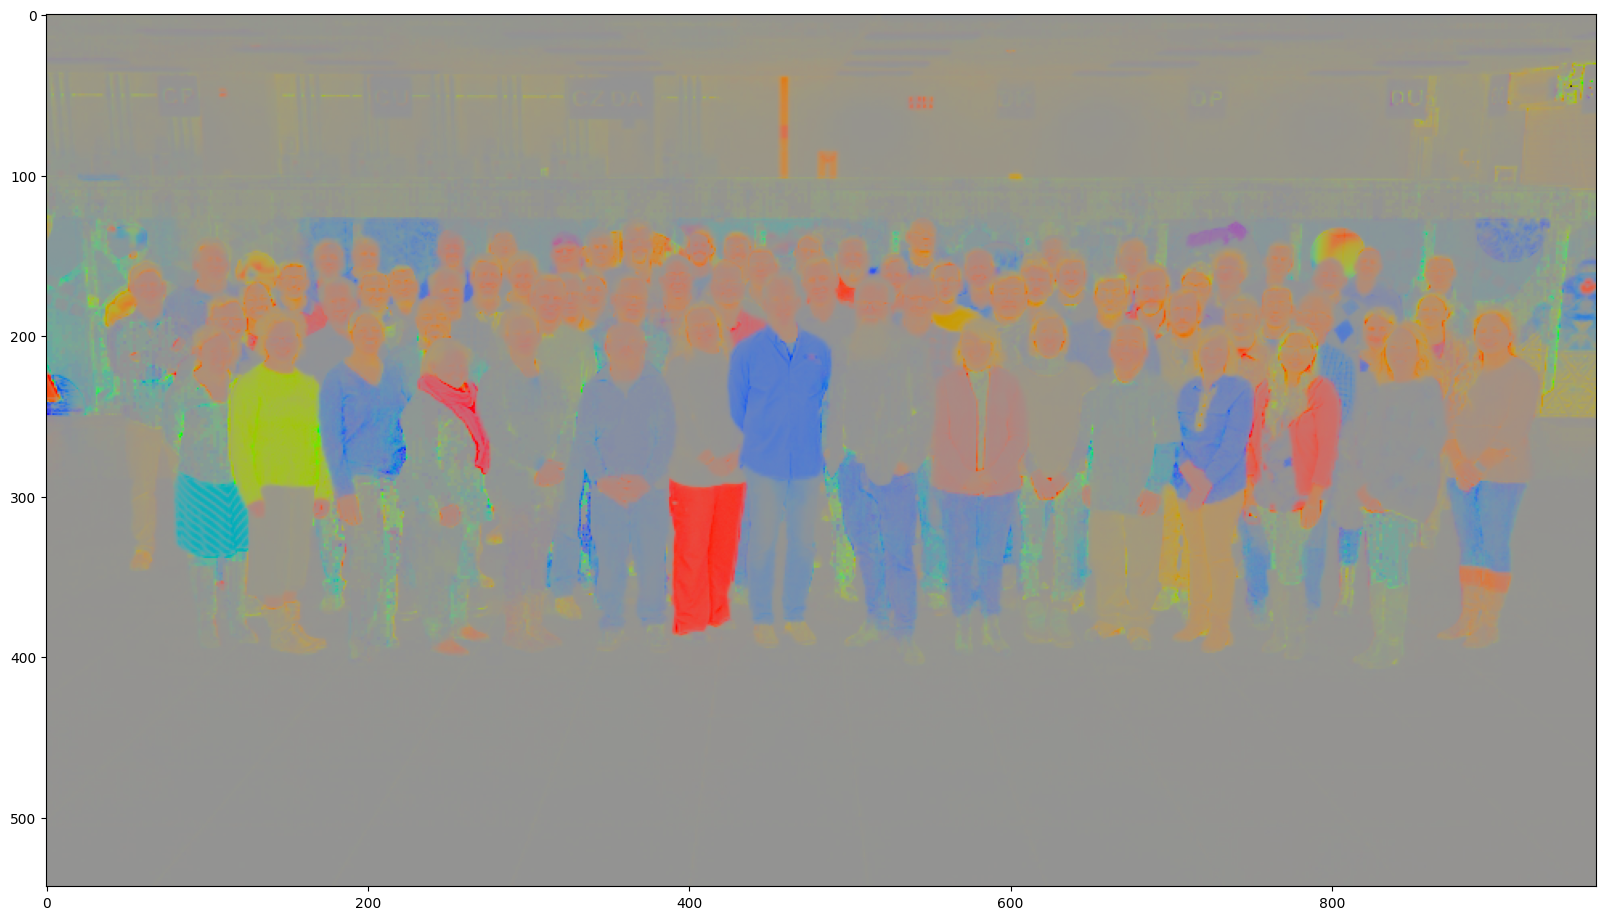

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


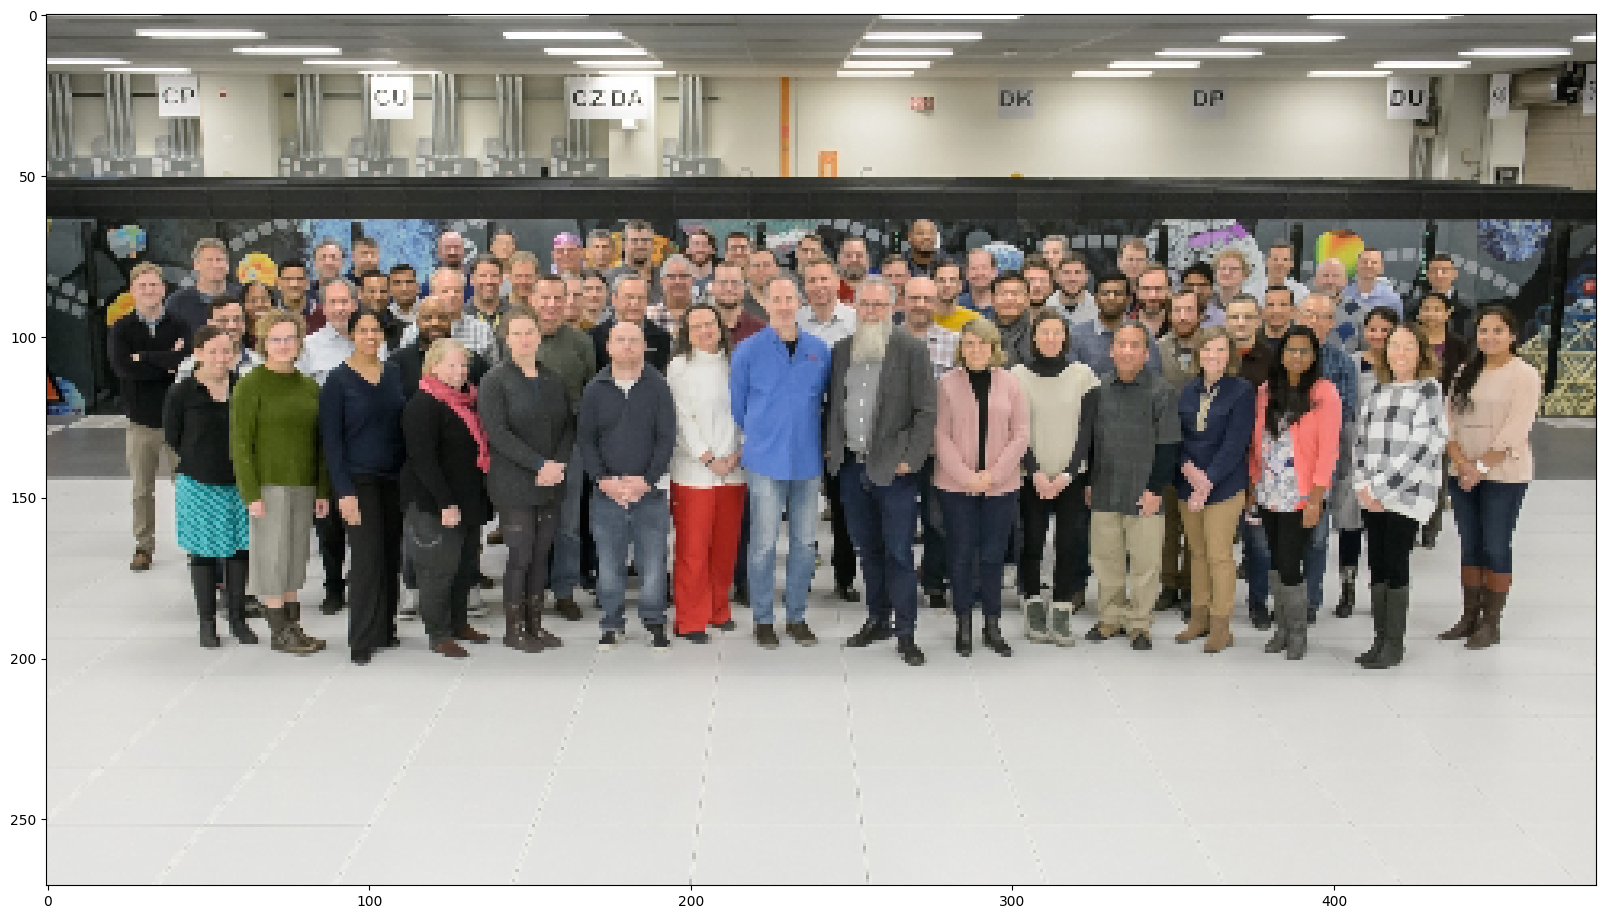

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](residual_layer.png)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](resnet_comparison.png)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [7]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

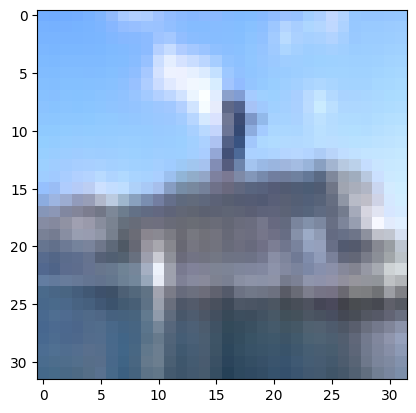

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [31]:
model = Classifier(32, 2, 16)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 64, 16, 16]         --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [32]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [33]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [34]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [35]:
from tqdm.notebook import tqdm


epochs = 10
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.740, accuracy: 36.903


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.732, accuracy: 36.462


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.454, accuracy: 47.876


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.443, accuracy: 47.716


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.167, accuracy: 58.471


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.172, accuracy: 57.723


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.015, accuracy: 63.965


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.041, accuracy: 62.747


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.853, accuracy: 69.806


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.891, accuracy: 67.909


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.751, accuracy: 74.002


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.815, accuracy: 70.965


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.661, accuracy: 76.904


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.736, accuracy: 73.487


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.578, accuracy: 79.860


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.676, accuracy: 76.325


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.482, accuracy: 83.424


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.614, accuracy: 78.313


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.465, accuracy: 83.813


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.627, accuracy: 77.858


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

# **Run1**

model = Classifier(64, 4, 2)

Train Epoch 0: 100%
313/313 [00:09<00:00, 33.84it/s]
Validate (train) Epoch 0: 100%
313/313 [00:04<00:00, 67.77it/s]

Epoch 0: training loss: 1.622, accuracy: 40.900

Validate Epoch 0: 100%
79/79 [00:01<00:00, 66.59it/s]

Epoch 0: validation loss: 1.618, accuracy: 40.704

Train Epoch 1: 100%
313/313 [00:08<00:00, 38.25it/s]
Validate (train) Epoch 1: 100%
313/313 [00:04<00:00, 67.47it/s]

Epoch 1: training loss: 1.367, accuracy: 50.659

Validate Epoch 1: 100%
79/79 [00:01<00:00, 67.37it/s]

Epoch 1: validation loss: 1.377, accuracy: 49.328

Train Epoch 2: 100%
313/313 [00:08<00:00, 38.44it/s]
Validate (train) Epoch 2: 100%
313/313 [00:04<00:00, 68.71it/s]

Epoch 2: training loss: 1.201, accuracy: 57.498

Validate Epoch 2: 100%
79/79 [00:01<00:00, 66.63it/s]

Epoch 2: validation loss: 1.232, accuracy: 55.904

Train Epoch 3: 100%
313/313 [00:08<00:00, 38.26it/s]
Validate (train) Epoch 3: 100%
313/313 [00:04<00:00, 69.08it/s]

Epoch 3: training loss: 1.069, accuracy: 62.058

Validate Epoch 3: 100%
79/79 [00:01<00:00, 67.26it/s]

Epoch 3: validation loss: 1.143, accuracy: 58.169

Train Epoch 4: 100%
313/313 [00:08<00:00, 38.29it/s]
Validate (train) Epoch 4: 100%
313/313 [00:04<00:00, 68.58it/s]

Epoch 4: training loss: 0.941, accuracy: 66.693

Validate Epoch 4: 100%
79/79 [00:01<00:00, 67.42it/s]

Epoch 4: validation loss: 1.030, accuracy: 63.123

Train Epoch 5: 100%
313/313 [00:08<00:00, 38.30it/s]
Validate (train) Epoch 5: 100%
313/313 [00:04<00:00, 69.01it/s]

Epoch 5: training loss: 0.815, accuracy: 71.229

Validate Epoch 5: 100%
79/79 [00:01<00:00, 67.90it/s]

Epoch 5: validation loss: 0.951, accuracy: 65.665

Train Epoch 6: 100%
313/313 [00:08<00:00, 38.37it/s]
Validate (train) Epoch 6: 100%
313/313 [00:04<00:00, 68.69it/s]

Epoch 6: training loss: 0.750, accuracy: 73.465

Validate Epoch 6: 100%
79/79 [00:01<00:00, 67.49it/s]

Epoch 6: validation loss: 0.908, accuracy: 67.356

Train Epoch 7: 100%
313/313 [00:08<00:00, 38.29it/s]
Validate (train) Epoch 7: 100%
313/313 [00:04<00:00, 69.43it/s]

Epoch 7: training loss: 0.668, accuracy: 76.692

Validate Epoch 7: 100%
79/79 [00:01<00:00, 67.69it/s]

Epoch 7: validation loss: 0.909, accuracy: 68.621

Train Epoch 8: 100%
313/313 [00:08<00:00, 38.35it/s]
Validate (train) Epoch 8: 100%
313/313 [00:04<00:00, 68.53it/s]

Epoch 8: training loss: 0.587, accuracy: 79.710

Validate Epoch 8: 100%
79/79 [00:01<00:00, 67.70it/s]

Epoch 8: validation loss: 0.851, accuracy: 70.807

Train Epoch 9: 100%
313/313 [00:08<00:00, 38.25it/s]
Validate (train) Epoch 9: 100%
313/313 [00:04<00:00, 68.86it/s]

Epoch 9: training loss: 0.514, accuracy: 82.064

Validate Epoch 9: 100%
79/79 [00:01<00:00, 68.78it/s]

Epoch 9: validation loss: 0.833, accuracy: 71.292


# **Run2**

model = Classifier(128, 4, 2)


Train Epoch 0: 100%
313/313 [00:18<00:00, 17.98it/s]
Validate (train) Epoch 0: 100%
313/313 [00:05<00:00, 57.87it/s]

Epoch 0: training loss: 2.089, accuracy: 23.592

Validate Epoch 0: 100%
79/79 [00:01<00:00, 57.81it/s]

Epoch 0: validation loss: 2.081, accuracy: 23.922

Train Epoch 1: 100%
313/313 [00:17<00:00, 17.98it/s]
Validate (train) Epoch 1: 100%
313/313 [00:05<00:00, 57.81it/s]

Epoch 1: training loss: 1.665, accuracy: 38.131

Validate Epoch 1: 100%
79/79 [00:01<00:00, 57.69it/s]

Epoch 1: validation loss: 1.671, accuracy: 37.540

Train Epoch 2: 100%
313/313 [00:17<00:00, 17.95it/s]
Validate (train) Epoch 2: 100%
313/313 [00:05<00:00, 57.89it/s]

Epoch 2: training loss: 1.462, accuracy: 46.600

Validate Epoch 2: 100%
79/79 [00:01<00:00, 57.59it/s]

Epoch 2: validation loss: 1.469, accuracy: 45.214

Train Epoch 3: 100%
313/313 [00:17<00:00, 17.97it/s]
Validate (train) Epoch 3: 100%
313/313 [00:05<00:00, 57.83it/s]

Epoch 3: training loss: 1.361, accuracy: 50.180

Validate Epoch 3: 100%
79/79 [00:01<00:00, 57.87it/s]

Epoch 3: validation loss: 1.374, accuracy: 48.813

Train Epoch 4: 100%
313/313 [00:17<00:00, 17.98it/s]
Validate (train) Epoch 4: 100%
313/313 [00:05<00:00, 57.81it/s]

Epoch 4: training loss: 1.229, accuracy: 56.020

Validate Epoch 4: 100%
79/79 [00:01<00:00, 57.52it/s]

Epoch 4: validation loss: 1.259, accuracy: 54.440

Train Epoch 5: 100%
313/313 [00:17<00:00, 17.98it/s]
Validate (train) Epoch 5: 100%
313/313 [00:05<00:00, 58.10it/s]

Epoch 5: training loss: 1.087, accuracy: 60.740

Validate Epoch 5: 100%
79/79 [00:01<00:00, 57.71it/s]

Epoch 5: validation loss: 1.134, accuracy: 58.574

Train Epoch 6: 100%
313/313 [00:17<00:00, 17.96it/s]
Validate (train) Epoch 6: 100%
313/313 [00:05<00:00, 57.87it/s]

Epoch 6: training loss: 0.901, accuracy: 68.298

Validate Epoch 6: 100%
79/79 [00:01<00:00, 57.45it/s]

Epoch 6: validation loss: 0.977, accuracy: 65.061

Train Epoch 7: 100%
313/313 [00:17<00:00, 17.97it/s]
Validate (train) Epoch 7: 100%
313/313 [00:05<00:00, 58.07it/s]

Epoch 7: training loss: 0.792, accuracy: 71.905

Validate Epoch 7: 100%
79/79 [00:01<00:00, 57.44it/s]

Epoch 7: validation loss: 0.904, accuracy: 67.573

Train Epoch 8: 100%
313/313 [00:17<00:00, 17.95it/s]
Validate (train) Epoch 8: 100%
313/313 [00:05<00:00, 57.54it/s]

Epoch 8: training loss: 0.709, accuracy: 75.220

Validate Epoch 8: 100%
79/79 [00:01<00:00, 57.90it/s]

Epoch 8: validation loss: 0.849, accuracy: 69.818

Train Epoch 9: 100%
313/313 [00:17<00:00, 17.96it/s]
Validate (train) Epoch 9: 100%
313/313 [00:05<00:00, 57.54it/s]

Epoch 9: training loss: 0.613, accuracy: 78.477

Validate Epoch 9: 100%
79/79 [00:01<00:00, 57.30it/s]

Epoch 9: validation loss: 0.780, accuracy: 72.716


# **Run3**

model = Classifier(32, 4, 2)

Train Epoch 0: 100%
313/313 [00:04<00:00, 67.21it/s]
Validate (train) Epoch 0: 100%
313/313 [00:04<00:00, 68.64it/s]

Epoch 0: training loss: 1.523, accuracy: 45.298

Validate Epoch 0: 100%
79/79 [00:01<00:00, 67.53it/s]

Epoch 0: validation loss: 1.501, accuracy: 46.400

Train Epoch 1: 100%
313/313 [00:05<00:00, 65.12it/s]
Validate (train) Epoch 1: 100%
313/313 [00:04<00:00, 63.85it/s]

Epoch 1: training loss: 1.291, accuracy: 53.699

Validate Epoch 1: 100%
79/79 [00:01<00:00, 67.06it/s]

Epoch 1: validation loss: 1.309, accuracy: 52.749

Train Epoch 2: 100%
313/313 [00:05<00:00, 65.00it/s]
Validate (train) Epoch 2: 100%
313/313 [00:04<00:00, 64.17it/s]

Epoch 2: training loss: 1.101, accuracy: 60.685

Validate Epoch 2: 100%
79/79 [00:01<00:00, 66.53it/s]

Epoch 2: validation loss: 1.148, accuracy: 57.902

Train Epoch 3: 100%
313/313 [00:05<00:00, 65.85it/s]
Validate (train) Epoch 3: 100%
313/313 [00:04<00:00, 68.48it/s]

Epoch 3: training loss: 0.956, accuracy: 66.484

Validate Epoch 3: 100%
79/79 [00:01<00:00, 58.10it/s]

Epoch 3: validation loss: 1.040, accuracy: 62.579

Train Epoch 4: 100%
313/313 [00:04<00:00, 68.33it/s]
Validate (train) Epoch 4: 100%
313/313 [00:05<00:00, 63.69it/s]

Epoch 4: training loss: 0.817, accuracy: 71.169

Validate Epoch 4: 100%
79/79 [00:01<00:00, 66.73it/s]

Epoch 4: validation loss: 0.921, accuracy: 66.644

Train Epoch 5: 100%
313/313 [00:05<00:00, 67.20it/s]
Validate (train) Epoch 5: 100%
313/313 [00:04<00:00, 68.27it/s]

Epoch 5: training loss: 0.694, accuracy: 76.006

Validate Epoch 5: 100%
79/79 [00:01<00:00, 66.71it/s]

Epoch 5: validation loss: 0.843, accuracy: 69.917

Train Epoch 6: 100%
313/313 [00:04<00:00, 68.27it/s]
Validate (train) Epoch 6: 100%
313/313 [00:04<00:00, 64.06it/s]

Epoch 6: training loss: 0.641, accuracy: 77.284

Validate Epoch 6: 100%
79/79 [00:01<00:00, 67.62it/s]

Epoch 6: validation loss: 0.805, accuracy: 71.766

Train Epoch 7: 100%
313/313 [00:04<00:00, 65.79it/s]
Validate (train) Epoch 7: 100%
313/313 [00:04<00:00, 67.62it/s]

Epoch 7: training loss: 0.510, accuracy: 82.266

Validate Epoch 7: 100%
79/79 [00:01<00:00, 67.03it/s]

Epoch 7: validation loss: 0.726, accuracy: 74.397

Train Epoch 8: 100%
313/313 [00:04<00:00, 65.35it/s]
Validate (train) Epoch 8: 100%
313/313 [00:04<00:00, 65.17it/s]

Epoch 8: training loss: 0.458, accuracy: 84.288

Validate Epoch 8: 100%
79/79 [00:01<00:00, 67.76it/s]

Epoch 8: validation loss: 0.730, accuracy: 75.020

Train Epoch 9: 100%
313/313 [00:04<00:00, 67.82it/s]
Validate (train) Epoch 9: 100%
313/313 [00:05<00:00, 63.54it/s]

Epoch 9: training loss: 0.386, accuracy: 86.759

Validate Epoch 9: 100%
79/79 [00:01<00:00, 67.06it/s]

Epoch 9: validation loss: 0.698, accuracy: 75.524


# **Run4**

model = Classifier(32, 4, 4)

Train Epoch 0: 100%
313/313 [00:07<00:00, 40.93it/s]
Validate (train) Epoch 0: 100%
313/313 [00:04<00:00, 70.54it/s]

Epoch 0: training loss: 1.671, accuracy: 39.781

Validate Epoch 0: 100%
79/79 [00:01<00:00, 66.96it/s]

Epoch 0: validation loss: 1.656, accuracy: 39.428

Train Epoch 1: 100%
313/313 [00:07<00:00, 40.97it/s]
Validate (train) Epoch 1: 100%
313/313 [00:04<00:00, 70.60it/s]

Epoch 1: training loss: 1.437, accuracy: 48.792

Validate Epoch 1: 100%
79/79 [00:01<00:00, 68.83it/s]

Epoch 1: validation loss: 1.442, accuracy: 47.973

Train Epoch 2: 100%
313/313 [00:07<00:00, 41.02it/s]
Validate (train) Epoch 2: 100%
313/313 [00:04<00:00, 68.23it/s]

Epoch 2: training loss: 1.204, accuracy: 57.306

Validate Epoch 2: 100%
79/79 [00:01<00:00, 68.72it/s]

Epoch 2: validation loss: 1.237, accuracy: 55.706

Train Epoch 3: 100%
313/313 [00:07<00:00, 40.99it/s]
Validate (train) Epoch 3: 100%
313/313 [00:04<00:00, 67.27it/s]

Epoch 3: training loss: 1.037, accuracy: 63.181

Validate Epoch 3: 100%
79/79 [00:01<00:00, 69.02it/s]

Epoch 3: validation loss: 1.098, accuracy: 60.107

Train Epoch 4: 100%
313/313 [00:07<00:00, 41.20it/s]
Validate (train) Epoch 4: 100%
313/313 [00:04<00:00, 70.17it/s]

Epoch 4: training loss: 0.936, accuracy: 66.823

Validate Epoch 4: 100%
79/79 [00:01<00:00, 69.91it/s]

Epoch 4: validation loss: 1.052, accuracy: 62.273

Train Epoch 5: 100%
313/313 [00:07<00:00, 41.11it/s]
Validate (train) Epoch 5: 100%
313/313 [00:04<00:00, 66.90it/s]

Epoch 5: training loss: 0.777, accuracy: 72.711

Validate Epoch 5: 100%
79/79 [00:01<00:00, 68.84it/s]

Epoch 5: validation loss: 0.932, accuracy: 66.594

Train Epoch 6: 100%
313/313 [00:07<00:00, 41.14it/s]
Validate (train) Epoch 6: 100%
313/313 [00:04<00:00, 70.27it/s]

Epoch 6: training loss: 0.699, accuracy: 75.419

Validate Epoch 6: 100%
79/79 [00:01<00:00, 68.61it/s]

Epoch 6: validation loss: 0.894, accuracy: 68.483

Train Epoch 7: 100%
313/313 [00:07<00:00, 41.12it/s]
Validate (train) Epoch 7: 100%
313/313 [00:04<00:00, 64.39it/s]

Epoch 7: training loss: 0.566, accuracy: 80.466

Validate Epoch 7: 100%
79/79 [00:01<00:00, 70.01it/s]

Epoch 7: validation loss: 0.805, accuracy: 71.193

Train Epoch 8: 100%
313/313 [00:07<00:00, 41.17it/s]
Validate (train) Epoch 8: 100%
313/313 [00:04<00:00, 67.09it/s]

Epoch 8: training loss: 0.497, accuracy: 82.990

Validate Epoch 8: 100%
79/79 [00:01<00:00, 69.64it/s]

Epoch 8: validation loss: 0.808, accuracy: 71.905

Train Epoch 9: 100%
313/313 [00:07<00:00, 41.00it/s]
Validate (train) Epoch 9: 100%
313/313 [00:04<00:00, 68.14it/s]

Epoch 9: training loss: 0.459, accuracy: 84.135

Validate Epoch 9: 100%
79/79 [00:01<00:00, 69.75it/s]

Epoch 9: validation loss: 0.810, accuracy: 71.727


# **Run5**

model = Classifier(32, 2, 16)

Train Epoch 0: 100%
313/313 [00:19<00:00, 16.14it/s]
Validate (train) Epoch 0: 100%
313/313 [00:06<00:00, 48.27it/s]

Epoch 0: training loss: 1.740, accuracy: 36.903

Validate Epoch 0: 100%
79/79 [00:01<00:00, 48.74it/s]

Epoch 0: validation loss: 1.732, accuracy: 36.462

Train Epoch 1: 100%
313/313 [00:19<00:00, 16.11it/s]
Validate (train) Epoch 1: 100%
313/313 [00:06<00:00, 48.52it/s]

Epoch 1: training loss: 1.454, accuracy: 47.876

Validate Epoch 1: 100%
79/79 [00:01<00:00, 48.72it/s]

Epoch 1: validation loss: 1.443, accuracy: 47.716

Train Epoch 2: 100%
313/313 [00:19<00:00, 16.10it/s]
Validate (train) Epoch 2: 100%
313/313 [00:06<00:00, 48.70it/s]

Epoch 2: training loss: 1.167, accuracy: 58.471

Validate Epoch 2: 100%
79/79 [00:01<00:00, 48.73it/s]

Epoch 2: validation loss: 1.172, accuracy: 57.723

Train Epoch 3: 100%
313/313 [00:19<00:00, 16.13it/s]
Validate (train) Epoch 3: 100%
313/313 [00:06<00:00, 48.73it/s]

Epoch 3: training loss: 1.015, accuracy: 63.965

Validate Epoch 3: 100%
79/79 [00:01<00:00, 48.79it/s]

Epoch 3: validation loss: 1.041, accuracy: 62.747

Train Epoch 4: 100%
313/313 [00:19<00:00, 16.15it/s]
Validate (train) Epoch 4: 100%
313/313 [00:06<00:00, 48.57it/s]

Epoch 4: training loss: 0.853, accuracy: 69.806

Validate Epoch 4: 100%
79/79 [00:01<00:00, 48.70it/s]

Epoch 4: validation loss: 0.891, accuracy: 67.909

Train Epoch 5: 100%
313/313 [00:19<00:00, 16.12it/s]
Validate (train) Epoch 5: 100%
313/313 [00:06<00:00, 48.73it/s]

Epoch 5: training loss: 0.751, accuracy: 74.002

Validate Epoch 5: 100%
79/79 [00:01<00:00, 48.69it/s]

Epoch 5: validation loss: 0.815, accuracy: 70.965

Train Epoch 6: 100%
313/313 [00:19<00:00, 16.10it/s]
Validate (train) Epoch 6: 100%
313/313 [00:06<00:00, 48.65it/s]

Epoch 6: training loss: 0.661, accuracy: 76.904

Validate Epoch 6: 100%
79/79 [00:01<00:00, 48.68it/s]

Epoch 6: validation loss: 0.736, accuracy: 73.487

Train Epoch 7: 100%
313/313 [00:19<00:00, 16.11it/s]
Validate (train) Epoch 7: 100%
313/313 [00:06<00:00, 48.69it/s]

Epoch 7: training loss: 0.578, accuracy: 79.860

Validate Epoch 7: 100%
79/79 [00:01<00:00, 48.67it/s]

Epoch 7: validation loss: 0.676, accuracy: 76.325

Train Epoch 8: 100%
313/313 [00:19<00:00, 16.12it/s]
Validate (train) Epoch 8: 100%
313/313 [00:06<00:00, 48.65it/s]

Epoch 8: training loss: 0.482, accuracy: 83.424

Validate Epoch 8: 100%
79/79 [00:01<00:00, 48.74it/s]

Epoch 8: validation loss: 0.614, accuracy: 78.313

Train Epoch 9: 100%
313/313 [00:19<00:00, 14.89it/s]
Validate (train) Epoch 9: 100%
313/313 [00:06<00:00, 48.73it/s]

Epoch 9: training loss: 0.465, accuracy: 83.813

Validate Epoch 9: 100%
79/79 [00:01<00:00, 48.57it/s]

Epoch 9: validation loss: 0.627, accuracy: 77.858


Increasing the filter size will improve performance of CNN since the filters extract features from the images.
Also, increasing the convnext block with more filters and more conv layers depthwise gave better performance in Run5. 